In [1]:
%%configure -f
{"driverMemory": "6000M"}

In [2]:
import hail as hl
hl.init(sc)

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 3.1.2-amzn-0
SparkUI available at 
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.80-4ccfae1ff293
LOGGING: writing to 

In [3]:
validation_30x_uri= "SG10K-SV-Release-1.4-30x-validation.mt"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
mt = hl.read_matrix_table(validation_30x_uri)

mt.describe()
mt.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    '_old_sv_id': str
    'qual': float64
    'filters': set<str>
    'callers_info': struct {
        manta: struct {
            ABHet: float64, 
            ABHom: float64, 
            ABHetMulti: array<float64>, 
            ABHomMulti: array<float64>, 
            AC: array<int32>, 
            AF: array<float64>, 
            AN: int32, 
            CR: int32, 
            END: int32, 
            HOMSEQ: array<str>, 
            INV3: bool, 
            INV5: bool, 
            LEFT_SVINSSEQ: array<str>, 
            LOGF: float64, 
            MaxAAS: array<int32>, 
            MaxAASR: array<float64>, 
            MaxAltPP: int32, 
            MQ: int32, 
            MQsquared: int32, 
            NCLUSTERS: int32, 
            NGT: array<i

In [5]:
# add metadata
release14_sample_metadata_uri = "2021_06_18_supplier_metadata.n10714_replacespace.txt"

### import metadata
t = hl.import_table(release14_sample_metadata_uri, delimiter="\t", quote="\"", impute=True)
#t.describe()

## annotate the hail mt with metadata
t = t.rename({"NPM_Research_ID" : "s"})
t = t.key_by(t.s)
mt = mt.annotate_cols(metadata = t[mt.s])
mt.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'metadata': struct {
        Multiplex_Pool_ID: str, 
        Supplier_ID: str, 
        GIS_Internal_Sample_ID: str, 
        Site_Supplying_Sample: str, 
        Year_Of_Birth: int32, 
        Supplied_Gender: str, 
        Self_Reported_Ethnicity: str, 
        Extraction_Kit: str, 
        Date_Of_DNA_Extraction: str, 
        Plate_Position: str, 
        Plate_Name: str, 
        Version_Of_Consent_Form_Signed: str, 
        Sequencing_Depth: str, 
        NPM_Research_ID_Created_By_Username: str, 
        NPM_Research_ID_Creation_Date: str, 
        Comments_Entered_When_NPM_Research_ID_Created: str, 
        Description_Entered_When_NPM_Research_ID_Created: str, 
        ELM_Project_ID: str, 
        ELM_Project_Title: str, 
        ELM_Project_PI: str, 
        Species_Of_Sample_Sequenced: str, 
        Tehcnique_For_Sequencing: str, 
      

In [6]:
svtype_stats = mt.aggregate_cols(hl.struct( ethnicity_stat = hl.agg.counter(mt.metadata.Self_Reported_Ethnicity)))
print(svtype_stats.ethnicity_stat)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

frozendict({'Chinese': 1433, 'Indian': 198, 'Malay': 288, 'Others': 3})

In [6]:
%%sh
pip install boto3

In [7]:
import boto3
import io
import matplotlib.pyplot as plt
import seaborn as sns

def save_fig_to_s3(fig, bucket, key):
    img_data = io.BytesIO()
    fig.savefig(img_data, format='svg', dpi=300)
    img_data.seek(0)

    s3 = boto3.client('s3')
    response = s3.put_object(Bucket=bucket, Key=key, Body=img_data, ContentType='image/svg')
    print(response)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
import pandas as pd

_mt = (mt
        .group_rows_by(mt.callers_info.SVTYPE)
        .aggregate(
            sv_count = hl.agg.count_where(mt.GT.is_hom_var()) + hl.agg.count_where(mt.GT.is_het())
        )
      )

df = (_mt
      .annotate_cols(ethnicity = _mt.metadata.Self_Reported_Ethnicity)
      .rename({"SVTYPE": "sv_type"})
      .drop('metadata')
      .entries()
      .to_pandas()
     )
df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
0        DEL  WHB3374   Chinese      3191
1        DEL  WHB3375   Chinese      3408
2        DEL  WHB3376   Chinese      3368
3        DEL  WHB3377   Chinese      3326
4        DEL  WHB3378   Chinese      3301
...      ...      ...       ...       ...
5761     INS  WHB5465   Chinese      2008
5762     INS  WHB5466   Chinese      2048
5763     INS  WHB5467   Chinese      2022
5764     INS  WHB5468    Indian      2112
5765     INS  WHB5469   Chinese      2034

[5766 rows x 4 columns]
2024-09-02 10:45:10 Hail: WARN: entries(): Resulting entries table is sorted by '(row_key, col_key)'.
    To preserve row-major matrix table order, first unkey columns with 'key_cols_by()'
2024-09-02 10:45:24 Hail: INFO: Coerced sorted dataset
2024-09-02 10:45:24 Hail: INFO: Coerced dataset with out-of-order partitions.

In [9]:
# extract deletions
del_df = df[df['sv_type'] == "DEL"]
del_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
0        DEL  WHB3374   Chinese      3191
1        DEL  WHB3375   Chinese      3408
2        DEL  WHB3376   Chinese      3368
3        DEL  WHB3377   Chinese      3326
4        DEL  WHB3378   Chinese      3301
...      ...      ...       ...       ...
1917     DEL  WHB5465   Chinese      3260
1918     DEL  WHB5466   Chinese      3244
1919     DEL  WHB5467   Chinese      3238
1920     DEL  WHB5468    Indian      3232
1921     DEL  WHB5469   Chinese      3174

[1922 rows x 4 columns]

In [10]:
del_ethnic = del_df[del_df.ethnicity != "Others"]
del_ethnic

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
0        DEL  WHB3374   Chinese      3191
1        DEL  WHB3375   Chinese      3408
2        DEL  WHB3376   Chinese      3368
3        DEL  WHB3377   Chinese      3326
4        DEL  WHB3378   Chinese      3301
...      ...      ...       ...       ...
1917     DEL  WHB5465   Chinese      3260
1918     DEL  WHB5466   Chinese      3244
1919     DEL  WHB5467   Chinese      3238
1920     DEL  WHB5468    Indian      3232
1921     DEL  WHB5469   Chinese      3174

[1919 rows x 4 columns]

In [11]:
del_all = del_ethnic[["sv_type", "s", 'ethnicity', 'sv_count']].copy()
del_all['ethnicity'] = 'All'
del_all

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
0        DEL  WHB3374       All      3191
1        DEL  WHB3375       All      3408
2        DEL  WHB3376       All      3368
3        DEL  WHB3377       All      3326
4        DEL  WHB3378       All      3301
...      ...      ...       ...       ...
1917     DEL  WHB5465       All      3260
1918     DEL  WHB5466       All      3244
1919     DEL  WHB5467       All      3238
1920     DEL  WHB5468       All      3232
1921     DEL  WHB5469       All      3174

[1919 rows x 4 columns]

In [12]:
frames = [del_ethnic, del_all]
del_table = pd.concat(frames)
del_table

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
0        DEL  WHB3374   Chinese      3191
1        DEL  WHB3375   Chinese      3408
2        DEL  WHB3376   Chinese      3368
3        DEL  WHB3377   Chinese      3326
4        DEL  WHB3378   Chinese      3301
...      ...      ...       ...       ...
1917     DEL  WHB5465       All      3260
1918     DEL  WHB5466       All      3244
1919     DEL  WHB5467       All      3238
1920     DEL  WHB5468       All      3232
1921     DEL  WHB5469       All      3174

[3838 rows x 4 columns]

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
plt.cla()
fig = plt.figure()
sns.set(rc={'figure.figsize':(10,15)})
sns.set_theme(style='whitegrid')
ax = sns.violinplot(hue = "ethnicity",
                    y="sv_count",
                    x= "sv_type",
                    data=del_table,
                    palette = ['#D62628', '#9467BD','#2EA02B', '#A9A9A9'],
                      linewidth=2
)
ax.set_xlabel("Ethnicity",fontsize=20)
ax.set_ylabel("Number of SV",fontsize=20)
ax.tick_params(labelsize=20)

mean = del_table.groupby("ethnicity")["sv_count"].mean()
print(mean)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ethnicity
All        3200.076602
Chinese    3216.892533
Indian     3124.277778
Malay      3168.517361
Name: sv_count, dtype: float64

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

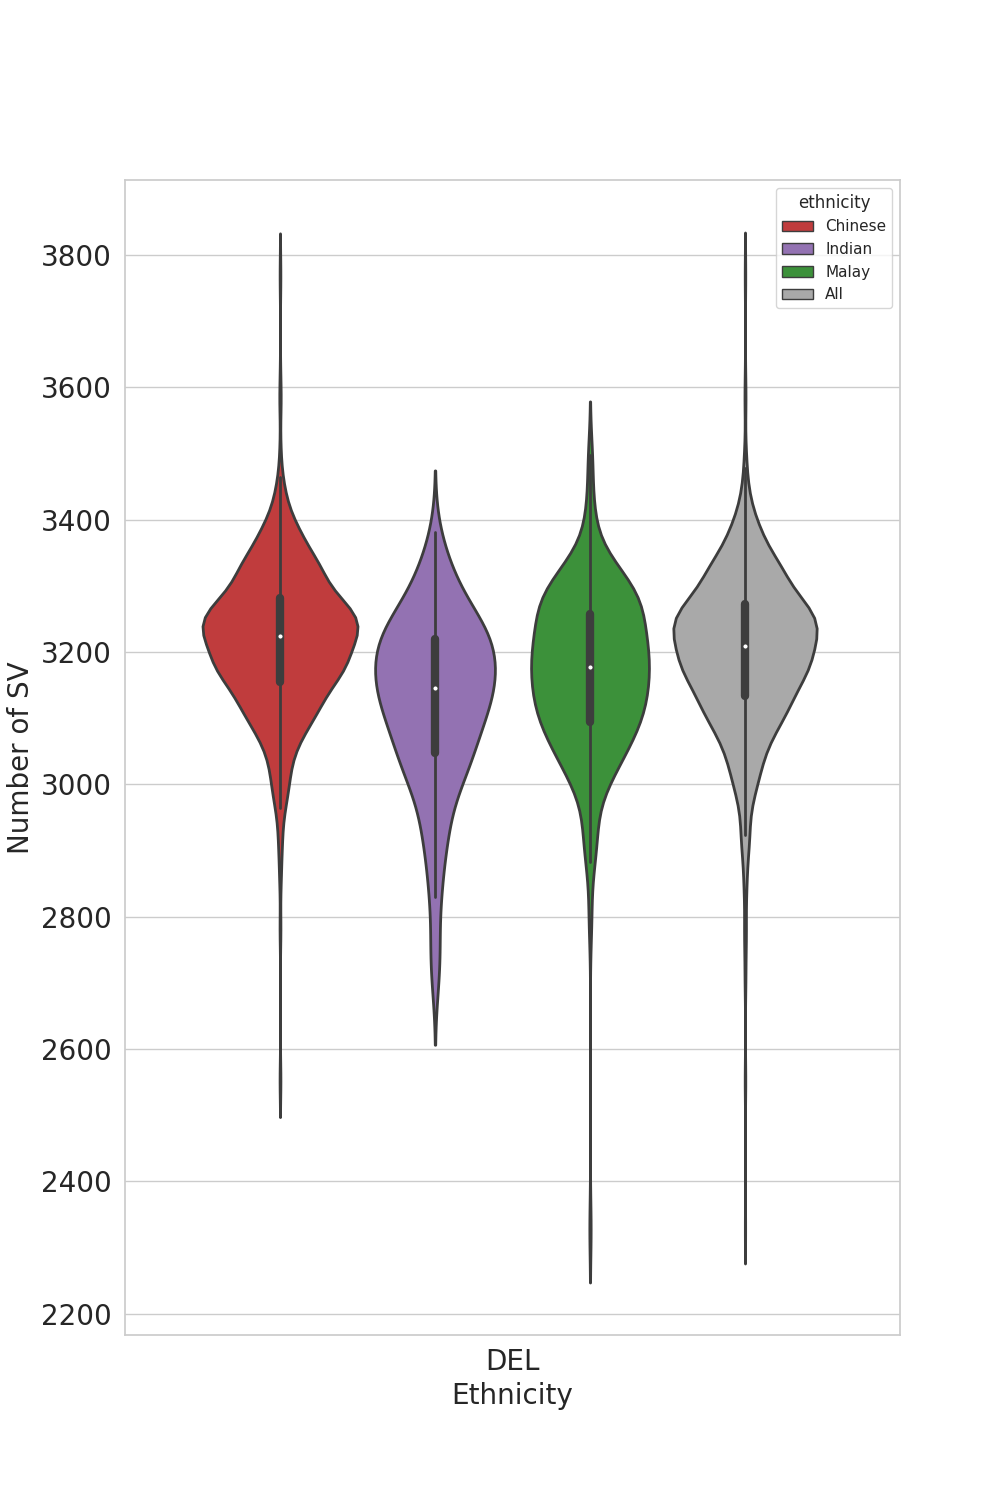

In [37]:
%matplot plt

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.clf()
plt.cla()
fig = plt.figure()
sns.set_theme(style='whitegrid')
ax = sns.violinplot(
                    y="sv_count",
                    x= "ethnicity",
                    data=del_table,
                    palette = ['#D62628', '#9467BD','#2EA02B', '#A9A9A9'], inner=None, linewidth=0, saturation=0.5)

sns.boxplot(data=del_table, y="sv_count",x= "ethnicity",  saturation=0.5, width=0.4,
            palette=['#D62628', '#9467BD','#2EA02B', '#A9A9A9'], boxprops={'zorder': 2}, ax=ax)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:xlabel='ethnicity', ylabel='sv_count'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

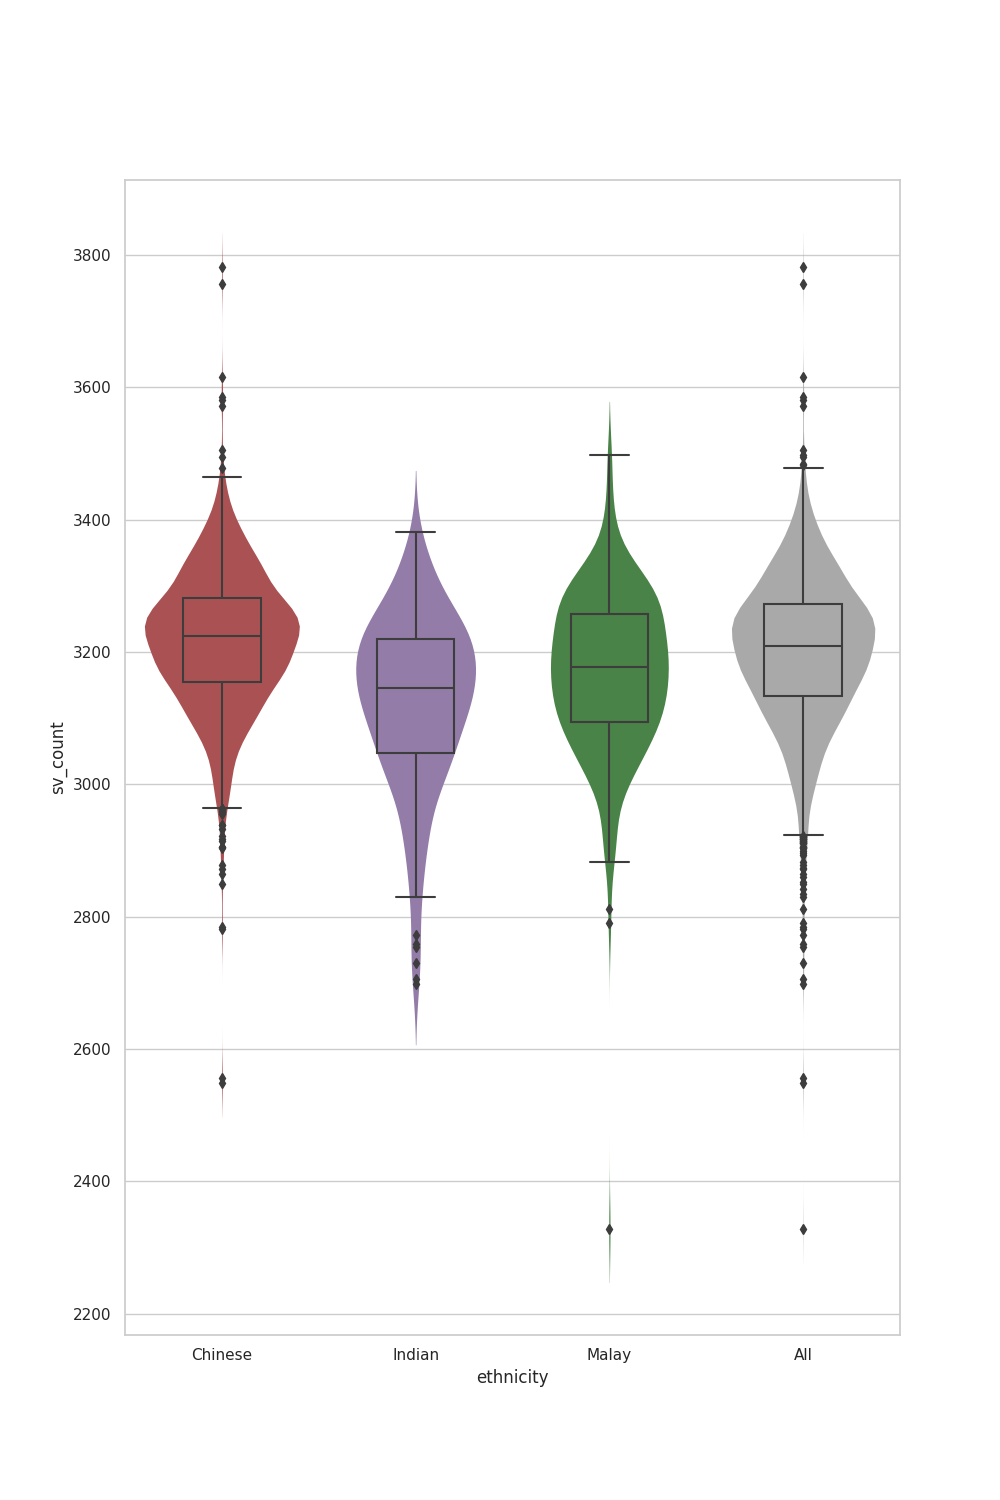

In [39]:
%matplot plt

In [40]:
save_fig_to_s3(plt, "Figures", "SupplementaryFig/30xvalidation_Numberofdeletionsperethnicgroup_rectangleboxplot_20240902_rectangesize.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Insertions

In [18]:
# extract insertions
ins_df = df[df['sv_type'] == "INS"]
ins_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
3844     INS  WHB3374   Chinese      2074
3845     INS  WHB3375   Chinese      2217
3846     INS  WHB3376   Chinese      2124
3847     INS  WHB3377   Chinese      2124
3848     INS  WHB3378   Chinese      2062
...      ...      ...       ...       ...
5761     INS  WHB5465   Chinese      2008
5762     INS  WHB5466   Chinese      2048
5763     INS  WHB5467   Chinese      2022
5764     INS  WHB5468    Indian      2112
5765     INS  WHB5469   Chinese      2034

[1922 rows x 4 columns]

In [19]:
ins_ethnic = ins_df[ins_df.ethnicity != "Others"]
ins_ethnic

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
3844     INS  WHB3374   Chinese      2074
3845     INS  WHB3375   Chinese      2217
3846     INS  WHB3376   Chinese      2124
3847     INS  WHB3377   Chinese      2124
3848     INS  WHB3378   Chinese      2062
...      ...      ...       ...       ...
5761     INS  WHB5465   Chinese      2008
5762     INS  WHB5466   Chinese      2048
5763     INS  WHB5467   Chinese      2022
5764     INS  WHB5468    Indian      2112
5765     INS  WHB5469   Chinese      2034

[1919 rows x 4 columns]

In [20]:
ins_all = ins_ethnic[["sv_type", "s", 'ethnicity', 'sv_count']].copy()
ins_all['ethnicity'] = 'All'
ins_all

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
3844     INS  WHB3374       All      2074
3845     INS  WHB3375       All      2217
3846     INS  WHB3376       All      2124
3847     INS  WHB3377       All      2124
3848     INS  WHB3378       All      2062
...      ...      ...       ...       ...
5761     INS  WHB5465       All      2008
5762     INS  WHB5466       All      2048
5763     INS  WHB5467       All      2022
5764     INS  WHB5468       All      2112
5765     INS  WHB5469       All      2034

[1919 rows x 4 columns]

In [21]:
frames_ins = [ins_ethnic, ins_all]
ins_table = pd.concat(frames_ins)
ins_table

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
3844     INS  WHB3374   Chinese      2074
3845     INS  WHB3375   Chinese      2217
3846     INS  WHB3376   Chinese      2124
3847     INS  WHB3377   Chinese      2124
3848     INS  WHB3378   Chinese      2062
...      ...      ...       ...       ...
5761     INS  WHB5465       All      2008
5762     INS  WHB5466       All      2048
5763     INS  WHB5467       All      2022
5764     INS  WHB5468       All      2112
5765     INS  WHB5469       All      2034

[3838 rows x 4 columns]

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
plt.cla()
fig = plt.figure()
sns.set(rc={'figure.figsize':(10,15)})
sns.set_theme(style='whitegrid')
ax = sns.violinplot(hue = "ethnicity",
                    y="sv_count",
                    x= "sv_type",
                    data=ins_table,
                    palette = ['#D62628', '#9467BD', '#2EA02B','#A9A9A9'],linewidth=2)
ax.set_xlabel("Ethnicity",fontsize=20)
ax.set_ylabel("Number of SV",fontsize=20)
ax.tick_params(labelsize=20)
mean = ins_table.groupby("ethnicity")["sv_count"].mean()
print(mean)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ethnicity
All        2030.762897
Chinese    2029.803210
Indian     2036.489899
Malay      2031.600694
Name: sv_count, dtype: float64

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

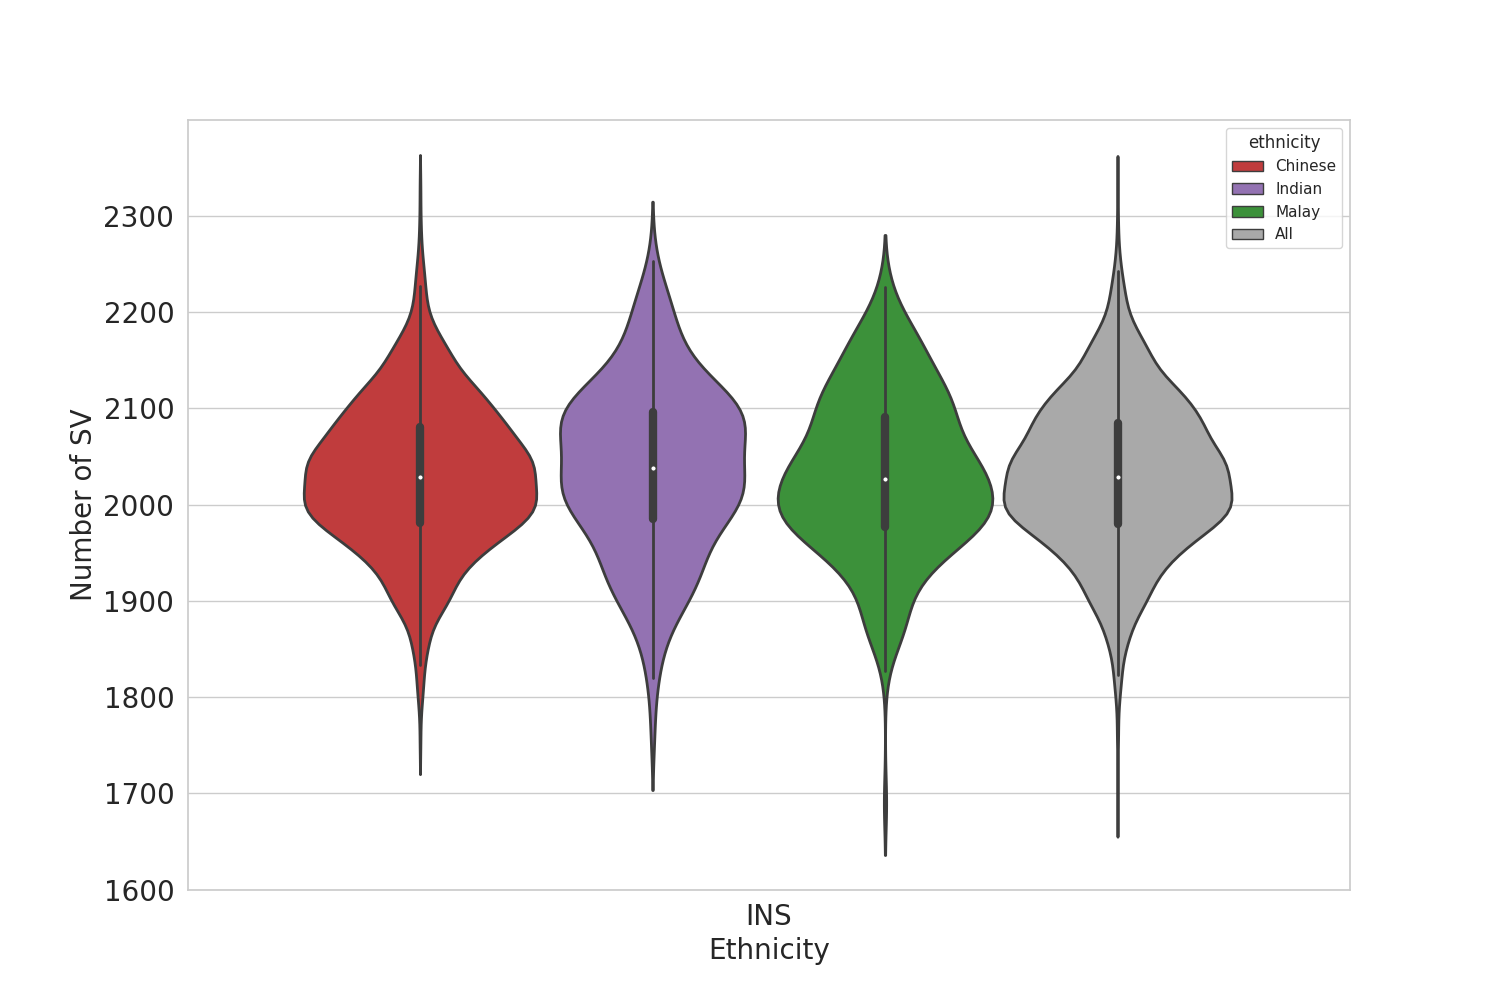

In [23]:
%matplot plt

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.clf()
plt.cla()
fig = plt.figure()
sns.set_theme(style='whitegrid')
ax = sns.violinplot(
                    y="sv_count",
                    x= "ethnicity",
                    data=ins_table,
                    palette = ['#D62628', '#9467BD','#2EA02B', '#A9A9A9'], inner=None, linewidth=0, saturation=0.5)

sns.boxplot(data=ins_table, y="sv_count",x= "ethnicity",  saturation=0.5, width=0.4,
            palette=['#D62628', '#9467BD','#2EA02B', '#A9A9A9'], boxprops={'zorder': 2}, ax=ax)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:xlabel='ethnicity', ylabel='sv_count'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

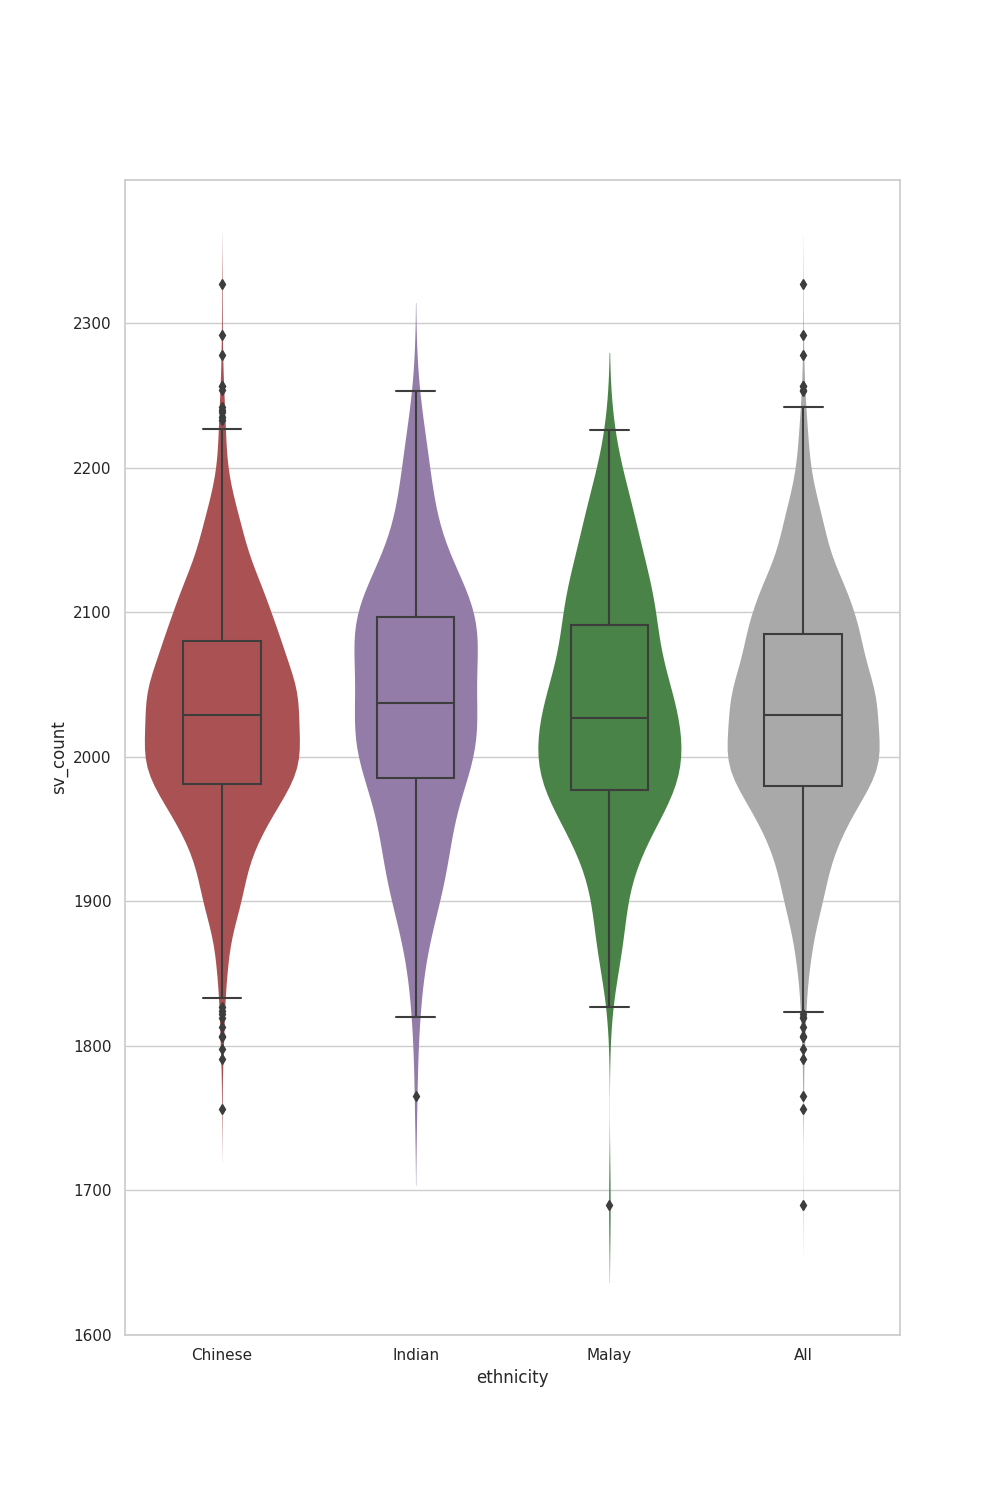

In [25]:
%matplot plt

In [26]:
save_fig_to_s3(plt, "Figures", "SupplementaryFig/30xValidation_NumberofInsertionsperethnicgroup_whitegrid_rectangleboxplot_20240902.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Duplications

In [27]:
# extract duplications
dup_df = df[df['sv_type'] == "DUP"]
dup_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
1922     DUP  WHB3374   Chinese      1496
1923     DUP  WHB3375   Chinese      1622
1924     DUP  WHB3376   Chinese      1650
1925     DUP  WHB3377   Chinese      1569
1926     DUP  WHB3378   Chinese      1507
...      ...      ...       ...       ...
3839     DUP  WHB5465   Chinese      1305
3840     DUP  WHB5466   Chinese      1229
3841     DUP  WHB5467   Chinese      1244
3842     DUP  WHB5468    Indian      1363
3843     DUP  WHB5469   Chinese      1349

[1922 rows x 4 columns]

In [28]:
dup_ethnic = dup_df[dup_df.ethnicity != "Others"]
dup_ethnic

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
1922     DUP  WHB3374   Chinese      1496
1923     DUP  WHB3375   Chinese      1622
1924     DUP  WHB3376   Chinese      1650
1925     DUP  WHB3377   Chinese      1569
1926     DUP  WHB3378   Chinese      1507
...      ...      ...       ...       ...
3839     DUP  WHB5465   Chinese      1305
3840     DUP  WHB5466   Chinese      1229
3841     DUP  WHB5467   Chinese      1244
3842     DUP  WHB5468    Indian      1363
3843     DUP  WHB5469   Chinese      1349

[1919 rows x 4 columns]

In [29]:
dup_all = dup_ethnic[["sv_type", "s", 'ethnicity', 'sv_count']].copy()
dup_all['ethnicity'] = 'All'
dup_all

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
1922     DUP  WHB3374       All      1496
1923     DUP  WHB3375       All      1622
1924     DUP  WHB3376       All      1650
1925     DUP  WHB3377       All      1569
1926     DUP  WHB3378       All      1507
...      ...      ...       ...       ...
3839     DUP  WHB5465       All      1305
3840     DUP  WHB5466       All      1229
3841     DUP  WHB5467       All      1244
3842     DUP  WHB5468       All      1363
3843     DUP  WHB5469       All      1349

[1919 rows x 4 columns]

In [30]:
frames_dup = [dup_ethnic, dup_all]
dup_table = pd.concat(frames_dup)
dup_table

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
1922     DUP  WHB3374   Chinese      1496
1923     DUP  WHB3375   Chinese      1622
1924     DUP  WHB3376   Chinese      1650
1925     DUP  WHB3377   Chinese      1569
1926     DUP  WHB3378   Chinese      1507
...      ...      ...       ...       ...
3839     DUP  WHB5465       All      1305
3840     DUP  WHB5466       All      1229
3841     DUP  WHB5467       All      1244
3842     DUP  WHB5468       All      1363
3843     DUP  WHB5469       All      1349

[3838 rows x 4 columns]

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
plt.cla()
fig = plt.figure()
sns.set(rc={'figure.figsize':(10,15)})
sns.set_theme(style='whitegrid')
ax = sns.violinplot(hue = "ethnicity",
                    y="sv_count",
                    x= "sv_type",
                    data=dup_table,
                    palette = ['#D62628', '#9467BD', '#2EA02B','#A9A9A9'], linewidth=2)
ax.set_xlabel("Ethnicity",fontsize=20)
ax.set_ylabel("Number of SV",fontsize=20)
ax.tick_params(labelsize=20)
mean = dup_table.groupby("ethnicity")["sv_count"].mean()
print(mean)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ethnicity
All        1434.826993
Chinese    1420.078158
Indian     1468.035354
Malay      1485.381944
Name: sv_count, dtype: float64

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

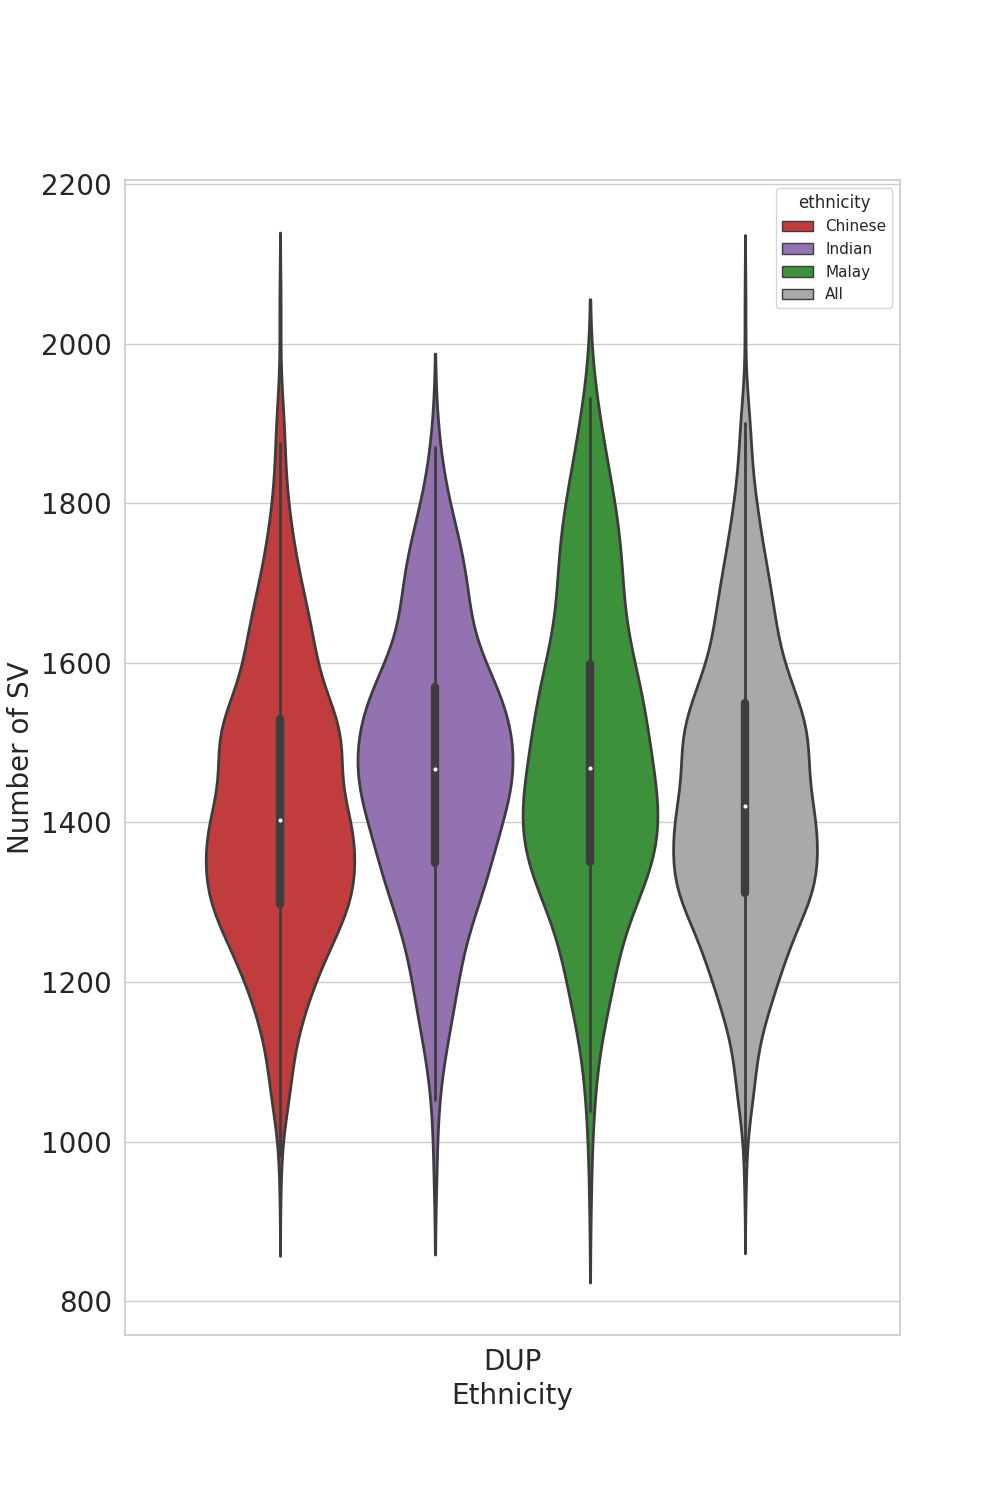

In [32]:
%matplot plt

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.clf()
plt.cla()
fig = plt.figure()
sns.set_theme(style='whitegrid')
ax = sns.violinplot(
                    y="sv_count",
                    x= "ethnicity",
                    data=dup_table,
                    palette = ['#D62628', '#9467BD','#2EA02B', '#A9A9A9'], inner=None, linewidth=0, saturation=0.5)

sns.boxplot(data=dup_table, y="sv_count",x= "ethnicity",  saturation=0.5, width=0.4,
            palette=['#D62628', '#9467BD','#2EA02B', '#A9A9A9'], boxprops={'zorder': 2}, ax=ax)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:xlabel='ethnicity', ylabel='sv_count'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

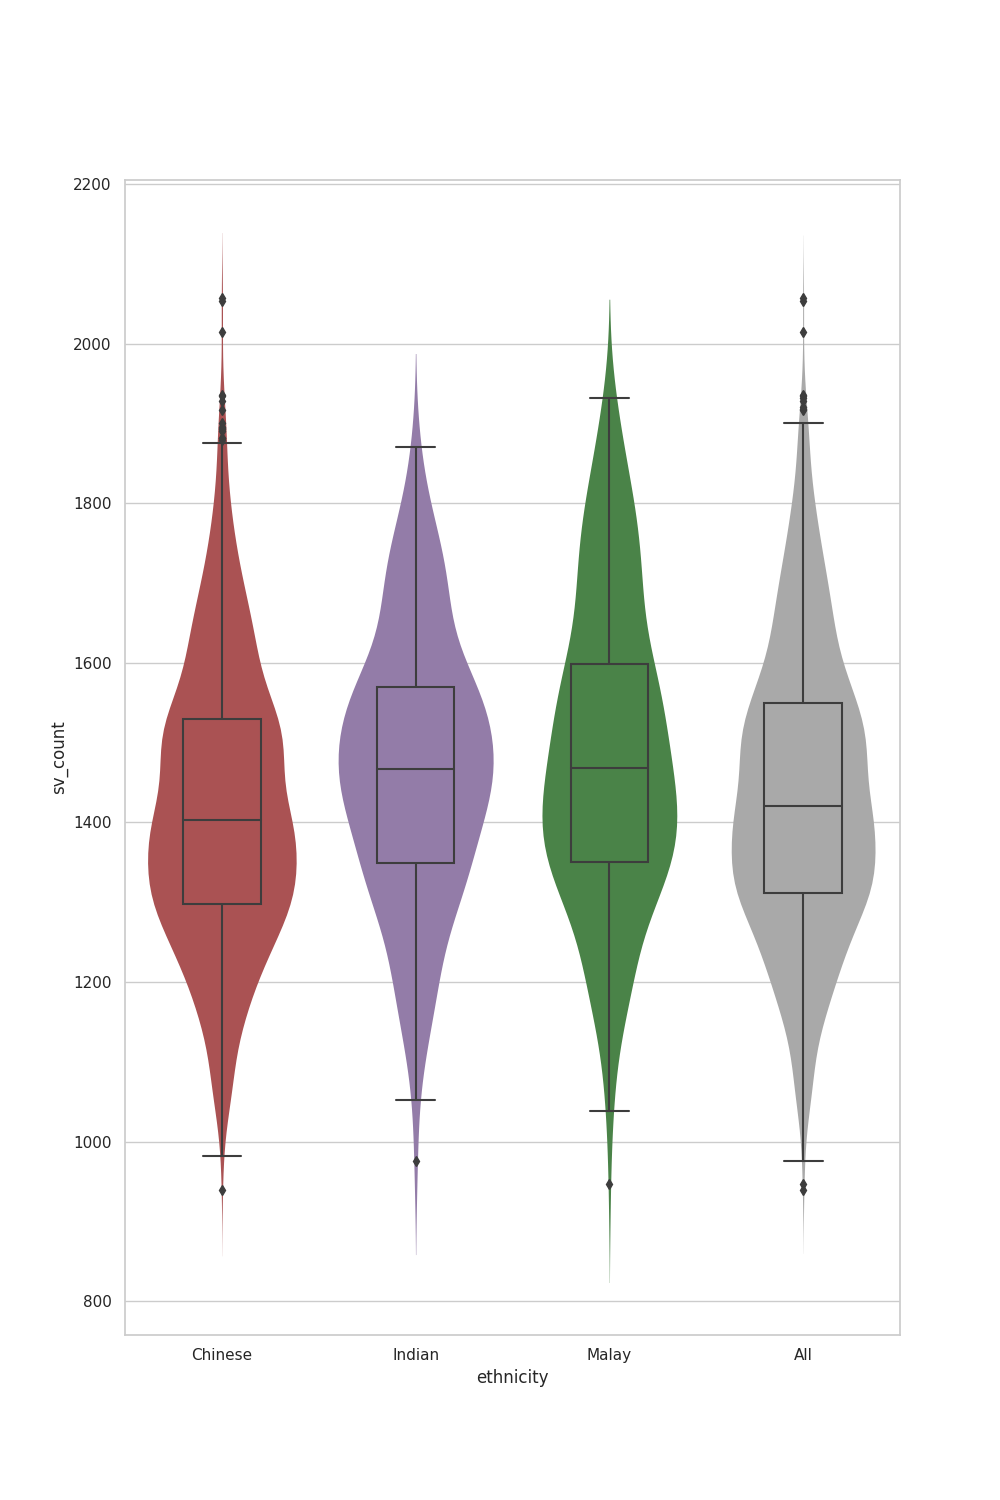

In [34]:
%matplot plt

In [35]:
save_fig_to_s3(plt, "Figures", "SupplementaryFig/30xValidation_NumberofDuplicationsperethnicgroup_whitegrid_rectangleboxplot_20240902.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…